Solubility prediction using molecular descriptors   ------ Gashaw M. Goshu 9/20/2020 -------

In [1]:
import sklearn
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from rdkit.ML.Descriptors import MoleculeDescriptors
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
import seaborn as sn
from xgboost import XGBRFRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
dataset = pd.read_csv('delaney-processed.csv')
dataset.describe()

,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
count,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000
mean,-2.988192,1.058511,203.937074,0.701241,1.390957,2.177305,34.872881,-3.050102
std,1.683220,0.238560,102.738077,1.089727,1.318286,2.640974,35.383593,2.096441
min,-9.702000,0.000000,16.043000,0.000000,0.000000,0.000000,0.000000,-11.600000
25%,-3.948250,1.000000,121.183000,0.000000,0.000000,0.000000,0.000000,-4.317500
50%,-2.870000,1.000000,182.179000,0.000000,1.000000,1.000000,26.300000,-2.860000
75%,-1.843750,1.000000,270.372000,1.000000,2.000000,3.000000,55.440000,-1.600000
max,1.091000,2.000000,780.949000,11.000000,8.000000,23.000000,268.680000,1.580000


In [3]:
# separate molecular features and target(solubility)
X, y = dataset.drop(columns=['measured log solubility in mols per litre','ESOL predicted log solubility in mols per litre']), dataset['measured log solubility in mols per litre']

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Compound ID                1128 non-null   object 
 1   Minimum Degree             1128 non-null   int64  
 2   Molecular Weight           1128 non-null   float64
 3   Number of H-Bond Donors    1128 non-null   int64  
 4   Number of Rings            1128 non-null   int64  
 5   Number of Rotatable Bonds  1128 non-null   int64  
 6   Polar Surface Area         1128 non-null   float64
 7   smiles                     1128 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 70.6+ KB


In [5]:
features =['Minimum Degree','Molecular Weight','Number of H-Bond Donors','Number of Rings',
           'Number of Rotatable Bonds','Polar Surface Area' ]

In [6]:
X =X[features ]
X

,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area
0,1,457.432,7,3,7,202.32
1,1,201.225,1,2,2,42.24
2,1,152.237,0,0,4,17.07
3,2,278.354,0,5,0,0.00
4,2,84.143,0,1,0,0.00
...,...,...,...,...,...,...
1123,1,197.381,0,0,0,0.00
1124,1,219.266,1,0,1,71.00
1125,1,246.359,0,0,7,18.46
1126,1,72.151,0,0,1,0.00


In [7]:
# train-test split
X_train, X_test, y_train, y_test = X[:790], X[790:], y[:790], y[790:]

In [8]:
X_train

,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area
0,1,457.432,7,3,7,202.32
1,1,201.225,1,2,2,42.24
2,1,152.237,0,0,4,17.07
3,2,278.354,0,5,0,0.00
4,2,84.143,0,1,0,0.00
...,...,...,...,...,...,...
785,1,60.056,2,0,0,69.11
786,1,68.119,0,0,1,0.00
787,1,235.906,0,1,0,0.00
788,1,270.501,1,0,16,20.23


In [9]:
y_train

0     -0.77
1     -3.30
2     -2.06
3     -7.87
4     -1.33
       ... 
785    0.96
786   -1.64
787   -3.54
788   -8.40
789   -1.33
Name: measured log solubility in mols per litre, Length: 790, dtype: float64

In [10]:
# Randomforest regressor
rf = RandomForestRegressor(random_state=42)

In [11]:
# Data preprocessing using pipeline 
pipe = Pipeline(steps=[
        ('scale', StandardScaler()),
        ('preprocessor', SimpleImputer()),
        ('model', rf)])

In [12]:
# Model Training and prediction
pipe.fit(X_train,y_train) # training using 70% of the data
rf_prediction = pipe.predict(X_test) # predicting yield for 30% of the data

In [13]:
#Model accuracy using root mean square error 
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_prediction)) 
print('rmse:', rmse_rf)

rmse: 0.9197741412479017


In [14]:
# R^2 (coefficient of determination) regression score function: 
R2_rf =r2_score(y_test, rf_prediction)
print('R^2:', R2_rf)

R^2: 0.8129747883832784


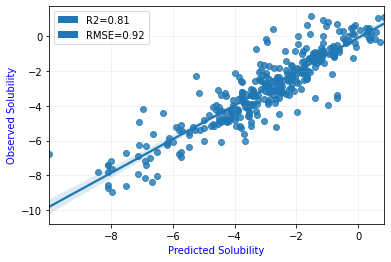

In [15]:
import matplotlib.patches as mpatches
sn.regplot(x=rf_prediction, y=y_test)
plt.xlabel('Predicted Solubility', color='blue')
plt.ylabel('Observed Solubility', color ='blue')
plt.grid(alpha=0.2)
R2_rf = mpatches.Patch(label="R2={:04.2f}".format(R2_rf))
rmse_rf = mpatches.Patch(label="RMSE={:04.2f}".format(rmse_rf))
plt.legend(handles=[R2_rf, rmse_rf])

In [16]:
# Feature importance Random forest
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(pipe, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

C:\Users\Gashaw\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Gashaw\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
1.1167 ± 0.0526,Molecular Weight
0.5996 ± 0.1230,Polar Surface Area
0.1260 ± 0.0252,Number of Rings
0.0647 ± 0.0146,Number of Rotatable Bonds
0.0420 ± 0.0080,Number of H-Bond Donors
0.0030 ± 0.0022,Minimum Degree


In [17]:
# XGBoost the most widely used ML model in kaggle competition
xgb = XGBRFRegressor(random_state = 42)

In [18]:
# Data preprocessing using pipeline 
pipe2 = Pipeline(steps=[
        ('scale', StandardScaler()),
        ('preprocessor', SimpleImputer()),
        ('model', xgb)])

In [19]:
# Training data
pipe2.fit(X_train,y_train)
xgb_prediction = pipe2.predict(X_test)

In [20]:
# Model accuracy using root mean square error 
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_prediction))  
print('rmse2:', xgb_rmse)

rmse2: 0.9547677126257441


In [21]:
# R^2 (coefficient of determination) regression score function: 
xgb_R2 =r2_score(y_test, xgb_prediction)
print('R^2:', xgb_R2)

R^2: 0.798473013025858


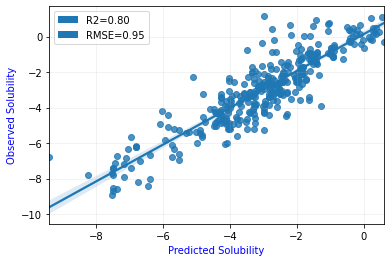

In [22]:
#plot predicted vs actual solubility
import matplotlib.patches as mpatches
sn.regplot(x=xgb_prediction, y=y_test)
plt.xlabel('Predicted Solubility', color='blue')
plt.ylabel('Observed Solubility', color ='blue')
plt.grid(alpha=0.2)
xgb_R2 = mpatches.Patch(label="R2={:04.2f}".format(xgb_R2))
xgb_rmse = mpatches.Patch(label="RMSE={:04.2f}".format(xgb_rmse))
plt.legend(handles=[xgb_R2, xgb_rmse])

In [23]:
# Feature importance Random forest
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(pipe2, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.9055 ± 0.0591,Molecular Weight
0.4663 ± 0.0919,Polar Surface Area
0.1209 ± 0.0099,Number of Rings
0.0638 ± 0.0115,Number of Rotatable Bonds
0.0401 ± 0.0066,Number of H-Bond Donors
0.0038 ± 0.0028,Minimum Degree
